# FRESH:COM



## Objective and Scope 

The energy community model FRESH:COM is developed within the [Horizon 2020 project openENTRANCE](https://openentrance.eu). 
The model is used for quantitative analyses as part of case study 2 - Behaviour of communities of actors.

### Expected results 
- Optimal design of the renewable technology portfolio for the community
- Time series of total and shared hourly local generation, storage operation, load, and purchases needed from the public grid 
    - For each community actor
    - For the community as a whole
- Revenues streams of community actors, distribution grid operator, and external supplier
- Determination of the net present value of investment and operational results up to 15 years
- Analyses for Austria and 4 European ‘reference countries’
- Quantitative upscaling of the short- and long-term local energy community potential is conducted for Europe as a whole 


## Nomenclature 
### Input data
Variable | Description      | Unit 
:--|:---------|:-----------:
$q^{PV}_{i,t}$    | PV generation of prosumer $i$                          | kWh
$q^{load}_{i,t}$  | Demand of prosumer $i$                                 | kWh
$SoC_{i}^{max}$   | Maximum capacity of prosumer $i$'s battery             | kWh
$q^{B_{max}}_{i}$ | Maximum (dis)charging power of prosumer $i$'s battery  | kW
$\eta^{B}$        | Efficiency of the batteries}                           | 
$w_{j}$           | Prosumer $j$'s weighting factor for marginal emissions | EUR/tCO2
$wtp_{i,j,t}$     | Willingness-to-pay of prosumer $j$                     | EUR/kWh
$p_{t}^{G_{in}}$  | Average spot market electricity price                  | EUR/kWh
$p_{t}^{G_{out}}$ | Retailer's electricity price                           | EUR/kWh
$e_{t}$           | Marginal emissions from the grid                       | tCO2/kWh

### Output data
Variable | Description      | Unit 
:--|:---------|:-----------:
$q^{G_{in}}_{i,t}$  | Purchase of prosumer $i$ from the grid     | kWh
$q^{G_{out}}_{i,t}$ | Sales from prosumer $i$ to the grid        | kWh
$q^{share}_{i,j,t}$ | Purchase of prosumer $j$ from prosumer $i$ | kWh
$q^{B_{in}}_{i,t}$  | Charging of prosumer $i$'s battery         | kWh
$q^{B_{out}}_{i,t}$ | Discharging of prosumer $i$'s battery      | kWh
$SoC_{i,t}$         | State of charge of prosumer $i$'s battery  | kWh

## Data and Packages

In [1]:
# import packages
import numpy as np
import pandas as pd
from pyomo.environ import *
import matplotlib.pyplot as plt
import seaborn as sns
#import pyam

%matplotlib inline

### Input data for energy communities

For details on the data format according to openENTRANCE see: https://github.com/openENTRANCE/nomenclature.



In [2]:
# read data sheets and save as pandas dataframes
# Prosumer data
load = pd.read_excel('Input_data/Input_data_community.xlsx', 
                     sheet_name='Demand', 
                     header=0, 
                     index_col='time')
PV = pd.read_excel('Input_data/Input_data_community.xlsx', 
                   sheet_name='PV', 
                   header=0, 
                   index_col='time')

# Grid parameter
emissions = pd.read_excel('Input_data/Input_data_community.xlsx', 
                          sheet_name='Marginal emissions', 
                          header=0, 
                          index_col='time')
prices = pd.read_excel('Input_data/Input_data_community.xlsx', 
                       sheet_name='Prices', 
                       header=0)


In [3]:
# prices = pyam.IamDataFrame(data='Input_data/Input_data_community.xlsx', sheet_name='Prices', encoding='utf-8')

In [4]:
# from datetime import datetime, timezone

#a = datetime.fromisoformat('2011-11-04 01:00+01:00')
#b = (a + a.utcoffset()).replace(tzinfo=None)
#b.isoformat(sep=' ', timespec='minutes')
# to_zone = tz.gettz('Austria')
# a.astimezone(to_zone)

In [5]:
load

,model,scenario,region,variable,unit,Prosumer 1,Prosumer 2,Prosumer 3,Prosumer 4,Prosumer 5,Prosumer 6,Prosumer 7,Prosumer 8,Prosumer 9,Prosumer 10
time,,,,,,,,,,,,,,,
2019-01-01 00:00+01:00,FRESH:COM v1.0,NaN,Austria,Final Energy|Residential and Commercial|Electr...,kWh,0.560675,0.190448,0.339625,0.295211,0.287922,0.551296,0.783245,0.596699,0.388367,0.399591
2019-01-01 01:00+01:00,FRESH:COM v1.0,NaN,Austria,Final Energy|Residential and Commercial|Electr...,kWh,0.547131,0.184950,0.213261,0.249684,0.260749,0.603248,0.211810,0.352198,0.245466,0.410864
2019-01-01 02:00+01:00,FRESH:COM v1.0,NaN,Austria,Final Energy|Residential and Commercial|Electr...,kWh,0.511453,0.167354,0.206496,0.296579,0.274643,0.584614,0.210178,0.272829,0.252640,0.312497
2019-01-01 03:00+01:00,FRESH:COM v1.0,NaN,Austria,Final Energy|Residential and Commercial|Electr...,kWh,0.458003,0.157157,0.214995,0.323098,1.056630,0.587524,0.208215,0.419140,0.335979,0.406965
2019-01-01 04:00+01:00,FRESH:COM v1.0,NaN,Austria,Final Energy|Residential and Commercial|Electr...,kWh,0.437814,0.180155,0.243081,0.271542,0.303982,0.528587,0.208120,0.343259,0.210874,0.402926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00+01:00,FRESH:COM v1.0,NaN,Austria,Final Energy|Residential and Commercial|Electr...,kWh,1.024138,0.220011,0.876033,1.168075,0.919636,2.866268,1.126393,1.251429,1.287123,0.998970
2019-12-31 20:00+01:00,FRESH:COM v1.0,NaN,Austria,Final Energy|Residential and Commercial|Electr...,kWh,0.938470,0.357786,0.822017,1.113036,0.615786,1.448335,0.183512,0.456565,1.335725,1.490958
2019-12-31 21:00+01:00,FRESH:COM v1.0,NaN,Austria,Final Energy|Residential and Commercial|Electr...,kWh,0.782867,0.627135,0.806216,1.380487,0.449766,1.913151,0.182009,0.471416,1.309891,1.705326


In [6]:
#load.region.str.contains('Au')

In [7]:
# filter time steps to desired range
# for a day use string e.g. '2019-01-01' for January 1st, 
# for a month e.g. '2019-01' for January, 
# for the whole year '2019'
time_steps = [s for s in list(load.index) if "2019-06" in s]
index_time = list(range(len(time_steps)))

In [8]:
time_steps

['2019-06-01 00:00+01:00',
 '2019-06-01 01:00+01:00',
 '2019-06-01 02:00+01:00',
 '2019-06-01 03:00+01:00',
 '2019-06-01 04:00+01:00',
 '2019-06-01 05:00+01:00',
 '2019-06-01 06:00+01:00',
 '2019-06-01 07:00+01:00',
 '2019-06-01 08:00+01:00',
 '2019-06-01 09:00+01:00',
 '2019-06-01 10:00+01:00',
 '2019-06-01 11:00+01:00',
 '2019-06-01 12:00+01:00',
 '2019-06-01 13:00+01:00',
 '2019-06-01 14:00+01:00',
 '2019-06-01 15:00+01:00',
 '2019-06-01 16:00+01:00',
 '2019-06-01 17:00+01:00',
 '2019-06-01 18:00+01:00',
 '2019-06-01 19:00+01:00',
 '2019-06-01 20:00+01:00',
 '2019-06-01 21:00+01:00',
 '2019-06-01 22:00+01:00',
 '2019-06-01 23:00+01:00',
 '2019-06-02 00:00+01:00',
 '2019-06-02 01:00+01:00',
 '2019-06-02 02:00+01:00',
 '2019-06-02 03:00+01:00',
 '2019-06-02 04:00+01:00',
 '2019-06-02 05:00+01:00',
 '2019-06-02 06:00+01:00',
 '2019-06-02 07:00+01:00',
 '2019-06-02 08:00+01:00',
 '2019-06-02 09:00+01:00',
 '2019-06-02 10:00+01:00',
 '2019-06-02 11:00+01:00',
 '2019-06-02 12:00+01:00',
 

In [9]:
# define a list with the prosumer names e.g. 'Prosumer 1', 'Household 1', etc. according to data sheet
prosumer = [s for s in list(load) if s.startswith("Prosumer")]
prosumer

['Prosumer 1',
 'Prosumer 2',
 'Prosumer 3',
 'Prosumer 4',
 'Prosumer 5',
 'Prosumer 6',
 'Prosumer 7',
 'Prosumer 8',
 'Prosumer 9',
 'Prosumer 10']

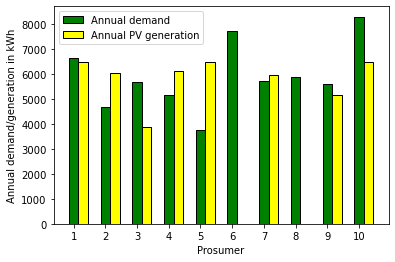

In [10]:
annual_load = [sum(load[s]) for s in prosumer] 
annual_PV = [sum(PV[s]) for s in prosumer]
barWidth = 0.3
r1 = np.arange(len(annual_load))
r2 = [x + barWidth for x in r1]
plt.bar(r1, annual_load, width = barWidth, color = 'green', edgecolor = 'black')
plt.bar(r2, annual_PV, width = barWidth, color = 'yellow', edgecolor = 'black')
plt.xticks(r1, np.arange(1,11))
plt.xlabel('Prosumer')
plt.ylabel('Annual demand/generation in kWh')
plt.legend(['Annual demand', 'Annual PV generation'])
plt.show()

### Prices 

In [11]:
a = prices[prices.variable == 'Price|Final Energy|Residential|Electricity'].index[0]
if "/MWh" in prices.unit[a]:
    unit_conv = 1000
elif "/kWh" in prices.unit[a]:
    unit_conv = 1
p_grid_in = prices.loc[a][2019]/unit_conv


In [12]:
a = prices[prices.variable == 'Price|Secondary Energy|Electricity'].index[0]
if "/MWh" in prices.unit[a]:
    unit_conv = 1000
elif "/kWh" in prices.unit[a]:
    unit_conv = 1
p_grid_out = prices.loc[a][2019]/unit_conv

In [13]:
print("Household electricity price p_grid_in is "+str(p_grid_in)+" EUR/kWh.\n")
print("Average spot market price p_grid_out is "+str(p_grid_out)+" EUR/kWh.")

Household electricity price p_grid_in is 0.2 EUR/kWh.

Average spot market price p_grid_out is 0.040159999999999994 EUR/kWh.


In [14]:
# load static prosumer parameter
# remark: not yet in IAMC format
prosumer_data = pd.read_excel('Input_data/Input_data_community.xlsx', 
                              sheet_name='Prosumer data', 
                              header=0, 
                              index_col='Data')

In [15]:
# show table / pandas dataframe of battery parameter
prosumer_data

,Prosumer 1,Prosumer 2,Prosumer 3,Prosumer 4,Prosumer 5,Prosumer 6,Prosumer 7,Prosumer 8,Prosumer 9,Prosumer 10
Data,,,,,,,,,,
q_bat_max,0,1,0,1,0,0,1,0,0,1
SoC_min,0,0,0,0,0,0,0,0,0,0
SoC_max,0,4,0,5,0,0,6,0,0,6
SoC_init,0,0,0,0,0,0,0,0,0,0
w,10,70,100,50,20,80,0,100,90,40


In [16]:
eta_battery = 0.9

In [17]:
load.columns

Index(['model', 'scenario', 'region', 'variable', 'unit', 'Prosumer 1',
       'Prosumer 2', 'Prosumer 3', 'Prosumer 4', 'Prosumer 5', 'Prosumer 6',
       'Prosumer 7', 'Prosumer 8', 'Prosumer 9', 'Prosumer 10'],
      dtype='object')

## Pyomo Optimization Model


In [18]:
# Define model as concrete model
model = ConcreteModel()

#Define optimization variables 
model.q_share = Var(time_steps, prosumer, prosumer, within = NonNegativeReals)
model.q_grid_in = Var(time_steps, prosumer, within = NonNegativeReals)
model.q_grid_out = Var(time_steps, prosumer, within = NonNegativeReals)
model.q_bat_in = Var(time_steps, prosumer, within = NonNegativeReals)
model.q_bat_out = Var(time_steps, prosumer, within = NonNegativeReals)
model.SoC = Var(time_steps, prosumer, within = NonNegativeReals)

In [19]:
prosumer_data.loc['SoC_max']['Prosumer 1']

0

In [20]:
# Define constraints
def load_constraint_rule(model, i, t):    
   return model.q_grid_in[t,i] + model.q_bat_out[t,i] + sum(model.q_share[t,j,i] for j in prosumer) == load.loc[t,i]
model.load_con = Constraint(prosumer, time_steps, rule = load_constraint_rule)

def PV_constraint_rule(model, i, t):    
   return model.q_grid_out[t,i] + model.q_bat_in[t,i] + sum(model.q_share[t,i,j] for j in prosumer) == PV.loc[t,i]
model.PV_con = Constraint(prosumer, time_steps, rule = PV_constraint_rule)

def SoC_min_constraint_rule(model, i, t):
    return model.SoC[t,i] >= prosumer_data.loc['SoC_min'][i]
model.SoC_min_con = Constraint(prosumer, time_steps, rule = SoC_min_constraint_rule)

def SoC_max_constraint_rule(model, i, t):
    return model.SoC[t,i] <= prosumer_data.loc['SoC_max'][i]
model.SoC_max_con = Constraint(prosumer, time_steps, rule = SoC_max_constraint_rule)

def q_bat_in_constraint_rule(model, i, t):
    return model.q_bat_in[t,i] <= prosumer_data.loc['q_bat_max'][i]
model.q_bat_in_con = Constraint(prosumer, time_steps, rule = q_bat_in_constraint_rule)

def q_bat_out_constraint_rule(model, i, t):
    return model.q_bat_out[t,i] <= prosumer_data.loc['q_bat_max'][i]
model.q_bat_out_con = Constraint(prosumer, time_steps, rule = q_bat_out_constraint_rule)

def SoC_constraint_rule(model, i, t):
    if t == 0:
        return model.SoC[time_steps[t],i] == prosumer_data.loc['SoC_init'][i] + model.q_bat_in[time_steps[t],i]*eta_battery - model.q_bat_out[time_steps[t],i]/eta_battery
    elif t > 0:
        return model.SoC[time_steps[t],i] == model.SoC[time_steps[t-1],i] + model.q_bat_in[time_steps[t],i] - model.q_bat_out[time_steps[t],i]
model.SoC_con = Constraint(prosumer, index_time, rule = SoC_constraint_rule)

In [21]:
#wtp = (p_grid_in + prosumer_data.loc['w']['Prosumer 1']*emissions.Emissions.loc['2019-01-01T00:00+01:00']/1000000)

In [22]:
# Objective function
community_welfare = {new_list: [] for new_list in prosumer}
prosumer_welfare = {new_list: [] for new_list in prosumer}

for i in prosumer:
    community_welfare[i] = sum(p_grid_in*model.q_grid_in[t,i]-p_grid_out*model.q_grid_out[t,i] for t in time_steps)
    prosumer_welfare[i] = sum((p_grid_in + prosumer_data.loc['w'][j]*emissions.Emissions.loc[t]/1000000)*model.q_share[t,i,j] for j in prosumer for t in time_steps)
    #prosumer_welfare[i] = sum(model.q_share[t,i,j] for j in prosumer for t in time_steps)

# prosumer i sells to prosumer j

In [23]:
model.obj = Objective(
    expr = sum(-community_welfare[i] + prosumer_welfare[i] for i in prosumer), 
    sense = maximize)

opt = SolverFactory('gurobi')
opt_success = opt.solve(model)

In [24]:
opt_success

{'Problem': [{'Name': 'x108001_copy', 'Lower bound': 441.59036706391635, 'Upper bound': 441.59036706391635, 'Number of objectives': 1, 'Number of constraints': 50401, 'Number of variables': 108001, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 108001, 'Number of nonzeros': 230391, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.3681468963623047', 'Error rc': 0, 'Time': 1.2657866477966309}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [25]:
value(model.obj)

441.59036706391424

## Show results of optimization problem

In [26]:
Q_share_total = pd.DataFrame(index=prosumer)

In [27]:
for j in prosumer:
    a = []
    for i in prosumer:
        a.append(value(sum(model.q_share[t,i,j] for t in time_steps)))
    Q_share_total[j] = a


In [28]:
Q_share_total

,Prosumer 1,Prosumer 2,Prosumer 3,Prosumer 4,Prosumer 5,Prosumer 6,Prosumer 7,Prosumer 8,Prosumer 9,Prosumer 10
Prosumer 1,179.501735,61.873820,59.803527,45.043524,33.006692,99.088129,52.814031,57.980811,64.295626,112.702735
Prosumer 2,17.075903,16.683926,36.497054,16.501976,9.531175,41.735720,18.519584,37.633790,23.577062,34.595121
Prosumer 3,20.395935,47.192476,46.632310,27.723445,28.260283,52.886135,29.533863,34.610201,43.963557,65.631580
Prosumer 4,10.119446,10.699120,19.456407,14.900216,10.388780,18.500359,13.672849,22.669924,20.154539,25.545139
Prosumer 5,14.636549,29.927272,31.567389,26.419179,10.799084,33.328313,15.284254,29.206274,21.954924,28.949138
Prosumer 6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Prosumer 7,15.158934,24.940108,25.636226,28.677575,9.706147,48.822798,23.619435,33.721389,20.699707,29.020342
Prosumer 8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Prosumer 9,32.377135,23.342321,34.039471,22.777655,30.045293,42.176947,35.567010,50.122625,33.850925,44.836563
Prosumer 10,15.747719,12.524849,17.941754,13.911329,13.072362,33.447648,11.155081,20.399577,11.864033,15.975310


<AxesSubplot:>

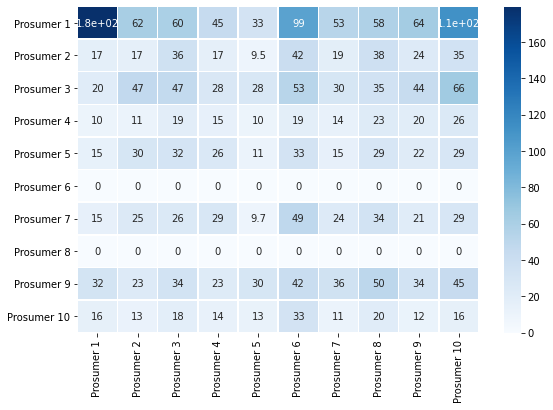

In [29]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(Q_share_total, annot=True, cmap="Blues", linewidths=.5, ax=ax)

In [30]:
value(model.q_share['2019-01-24 13:00+01:00','Prosumer 5','Prosumer 6'])

KeyError: "Index '('2019-01-24 13:00+01:00', 'Prosumer 5', 'Prosumer 6')' is not valid for indexed component 'q_share'"

In [ ]:
for j in prosumer:
    a = []
    for i in prosumer:
        a.append(value((model.q_share['2019-01-24 13:00+01:00',i,j])))
    Q_share_total[j] = a

In [ ]:
Q_share_total

In [ ]:
for i in prosumer:
    print(PV.loc['2019-01-24 13:00+01:00', i] - sum(Q_share_total.loc[i]) - value(model.q_grid_out['2019-01-24 13:00+01:00', i]) - value(model.q_bat_in['2019-01-24 13:00+01:00', i]))

In [ ]:
for i in prosumer:
    print(value(model.SoC['2019-01-24 13:00+01:00', i]))

In [ ]:
for i in prosumer:
    print(value(sum(model.q_bat_out[t,i] for t in time_steps)))